In [ ]:
!pip install torch scikit-learn


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import os
import math

# Thiết lập device cho PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Sử dụng device: {device}")

Sử dụng device: cuda


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
SEED = 1000

In [ ]:
def seed(SEED):
    torch.manual_seed(SEED)

In [ ]:
seed(SEED)

In [ ]:
DATA_PATH = r"/content/drive/MyDrive/Finance/process/BTC-USD.csv"

In [ ]:
df = pd.read_csv(DATA_PATH)
df.head()
# df = df.set_index("Open Time")
# df = df.drop(columns=["Volume"])
# df.head()

,Open Time,Open,High,Low,Close,Volume,SMA_14,EMA_14,RSI_14,Upper_Band,Lower_Band
0,1970-01-01 00:28:16.186800,27096.13,27107.77,27076.36,27103.02,366.15670,27145.031429,27115.659286,53.530659,27245.437055,26977.480945
1,1970-01-01 00:28:16.190400,27103.02,27147.00,27033.10,27109.75,766.63067,27143.667143,27114.871382,47.569109,27238.847543,26995.938457
2,1970-01-01 00:28:16.194000,27109.75,27187.99,27091.78,27180.37,365.73406,27148.840000,27123.604531,58.181572,27240.793205,27010.046795
3,1970-01-01 00:28:16.197600,27180.38,28065.51,27155.00,27996.43,7785.49229,27210.337143,27239.981260,84.966535,27575.229665,26772.664335
4,1970-01-01 00:28:16.201200,27996.43,28025.12,27861.47,27992.57,2561.49051,27265.680000,27340.326425,83.608634,27759.055698,26683.619302


In [ ]:
df = df.set_index("Open Time")
df = df.drop(columns = ["Volume"])
df.head()

,Open,High,Low,Close,SMA_14,EMA_14,RSI_14,Upper_Band,Lower_Band
Open Time,,,,,,,,,
1970-01-01 00:28:16.186800,27096.13,27107.77,27076.36,27103.02,27145.031429,27115.659286,53.530659,27245.437055,26977.480945
1970-01-01 00:28:16.190400,27103.02,27147.00,27033.10,27109.75,27143.667143,27114.871382,47.569109,27238.847543,26995.938457
1970-01-01 00:28:16.194000,27109.75,27187.99,27091.78,27180.37,27148.840000,27123.604531,58.181572,27240.793205,27010.046795
1970-01-01 00:28:16.197600,27180.38,28065.51,27155.00,27996.43,27210.337143,27239.981260,84.966535,27575.229665,26772.664335
1970-01-01 00:28:16.201200,27996.43,28025.12,27861.47,27992.57,27265.680000,27340.326425,83.608634,27759.055698,26683.619302


In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from typing import Dict, Tuple, List

# --- 1. LỚP DATASET TÙY CHỈNH CHO CHUỖI THỜI GIAN ---
class TimeSeriesDataset(Dataset):
    """
    Tạo Dataset PyTorch từ mảng NumPy đã chia chuỗi (sequence)
    """
    def __init__(self, sequences: np.ndarray, targets: np.ndarray):
        # Chuyển đổi từ NumPy sang Tensor
        self.sequences = torch.from_numpy(sequences).float() # X: input sequences
        self.targets = torch.from_numpy(targets).float()     # y: targets (mục tiêu dự đoán)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx]

# --- 2. HÀM CHIA CHUỖI (SEQUENCE) CẬP NHẬT ---
def create_sequences(feature_data: np.ndarray, target_data: np.ndarray, seq_length: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Chia dữ liệu thành các chuỗi đầu vào (X) và đầu ra dự đoán (y).

    Args:
        feature_data (np.ndarray): Dữ liệu đầu vào (features), đã chuẩn hóa.
        target_data (np.ndarray): Dữ liệu mục tiêu (targets), đã chuẩn hóa.
        seq_length (int): Chiều dài chuỗi thời gian.

    Returns:
        Tuple[np.ndarray, np.ndarray]: (X_sequences, y_targets)
    """
    X, y = [], []

    # Số lượng mẫu sau khi chia seq_length
    num_samples = min(len(feature_data), len(target_data)) - seq_length

    for i in range(num_samples):
        # Đầu vào X là chuỗi feature có độ dài seq_length
        seq_in = feature_data[i:(i + seq_length)]

        # Đầu ra y là giá trị mục tiêu ngay sau chuỗi đó (tại thời điểm t + seq_length)
        # Sử dụng target_data[i + seq_length]
        seq_out = target_data[i + seq_length]

        X.append(seq_in)
        y.append(seq_out)

    return np.array(X), np.array(y)

# --- 3. HÀM CHÍNH TẠO DATALOADERS CẬP NHẬT ---
def create_dataloaders(df: pd.DataFrame,
                       seq_length: int,
                       batch_size: int,
                       split: Dict[str, float],
                       target_cols: List[str]) -> Tuple[DataLoader, DataLoader, DataLoader, MinMaxScaler]:

    # Kiểm tra các cột mục tiêu có tồn tại không
    if not all(col in df.columns for col in target_cols):
        raise ValueError("Một hoặc nhiều cột mục tiêu (target_cols) không tồn tại trong DataFrame.")

    # 1. Tách Features và Targets
    # Các cột đầu vào (Features) là tất cả các cột trừ target_cols
    feature_cols = df.columns

    df_features = df[feature_cols]
    df_targets = df[target_cols]

    feature_data_raw = df_features.values
    target_data_raw = df_targets.values
    data_len = len(df)

    # Tính toán kích thước tập
    train_size = int(split['train'] * data_len)
    valid_size = int(split.get('valid', 0) * data_len)

    # 2. CHIA DỮ LIỆU THÔ (RAW SPLIT)

    # Chia tập Features
    train_features_raw = feature_data_raw[:train_size]
    valid_features_raw = feature_data_raw[train_size:train_size + valid_size]
    test_features_raw = feature_data_raw[train_size + valid_size:]

    # Chia tập Targets
    train_targets_raw = target_data_raw[:train_size]
    valid_targets_raw = target_data_raw[train_size:train_size + valid_size]
    test_targets_raw = target_data_raw[train_size + valid_size:]

    print(f"Kích thước tập (Features/Targets): Train={len(train_features_raw)}, Valid={len(valid_features_raw)}, Test={len(test_features_raw)}")

    # 3. CHUẨN HÓA (SCALING) TRÊN TẬP TRAIN

    # Khởi tạo Scaler (sử dụng một scaler duy nhất cho FEATURES và TARGETS để đảm bảo tính nhất quán nếu cùng là cột giá)
    # Tuy nhiên, ta dùng 2 Scaler để đảm bảo tính linh hoạt
    feature_scaler = MinMaxScaler(feature_range=(0, 1))
    target_scaler = MinMaxScaler(feature_range=(0, 1)) # Dùng để nghịch đảo (inverse transform) sau này

    # Fit và Transform CHỈ trên tập train (cho cả features và targets)
    train_features_scaled = feature_scaler.fit_transform(train_features_raw)
    valid_features_scaled = feature_scaler.transform(valid_features_raw)
    test_features_scaled = feature_scaler.transform(test_features_raw)

    train_targets_scaled = target_scaler.fit_transform(train_targets_raw)
    valid_targets_scaled = target_scaler.transform(valid_targets_raw)
    test_targets_scaled = target_scaler.transform(test_targets_raw)

    # 4. TẠO SEQUENCE (CHUỖI) VÀ DATALOADERS

    # Sử dụng hàm create_sequences đã cập nhật
    X_train, y_train = create_sequences(train_features_scaled, train_targets_scaled, seq_length)
    X_valid, y_valid = create_sequences(valid_features_scaled, valid_targets_scaled, seq_length)
    X_test, y_test = create_sequences(test_features_scaled, test_targets_scaled, seq_length)

    print(f"Kích thước sau khi chia seq: Train={len(X_train)}, Valid={len(X_valid)}, Test={len(X_test)}")

    # Tạo Dataset và DataLoader
    train_loader = DataLoader(TimeSeriesDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(TimeSeriesDataset(X_valid, y_valid), batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(TimeSeriesDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

    # Trả về DataLoader và Target Scaler (cần thiết cho việc nghịch đảo dự đoán)
    return train_loader, valid_loader, test_loader, target_scaler

In [ ]:
# 2. Thiết lập tham số
SEQ_LENGTH = 50
BATCH_SIZE = 64
SPLIT_RATIOS = {'train': 0.7, 'valid': 0.15, 'test': 0.15}
TARGET_COLUMNS = ['Open','High', 'Low', 'Close'] # Chỉ dự đoán cột 'Close'

In [ ]:
# 3. Chạy hàm chính
train_loader, valid_loader, test_loader, target_scaler = create_dataloaders(
    df=df,
    seq_length=SEQ_LENGTH,
    batch_size=BATCH_SIZE,
    split=SPLIT_RATIOS,
    target_cols=TARGET_COLUMNS # Truyền vào danh sách các cột mục tiêu
)

# 4. Kiểm tra kết quả
print("\nKiểm tra kích thước của một lô (batch):")
X_batch, y_batch = next(iter(train_loader))

# X_batch (Input Features): [batch_size, seq_length, num_feature_cols]
# (64, 30, 4) vì có 4 cột feature (Open, High, Low, Volume)
print(f"Input batch shape (X): {X_batch.shape}")

# y_batch (Targets): [batch_size, num_target_cols]
# (64, 1) vì có 1 cột target (Close)
print(f"Target batch shape (y): {y_batch.shape}")

Kích thước tập (Features/Targets): Train=10722, Valid=2297, Test=2299
Kích thước sau khi chia seq: Train=10672, Valid=2247, Test=2249

Kiểm tra kích thước của một lô (batch):
Input batch shape (X): torch.Size([64, 50, 9])
Target batch shape (y): torch.Size([64, 4])


In [ ]:
train_loader = train_loader

## BUILD MODEL
### 1. LSTM

In [ ]:

## Mô hình LSTM
class LSTM_Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM_Model, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM Layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # Output Layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Khởi tạo state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # LSTM forward
        out, _ = self.lstm(x, (h0, c0))

        # Lấy output cuối cùng
        out = self.fc(out[:, -1, :])

        return out

In [ ]:
## Mô hình Hybrid CNN-LSTM
class Hybrid_CNN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, seq_len):
        super(Hybrid_CNN_LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # CNN Layers (Input: B, F, L)
        self.cnn1 = nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

        # LSTM Layers (Input: B, L/2, 64)
        lstm_input_size = 64
        self.lstm = nn.LSTM(lstm_input_size, hidden_size, num_layers, batch_first=True)

        # Output Layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x shape: (B, L, F) -> Permute: (B, F, L)
        x = x.permute(0, 2, 1)

        # CNN forward
        x = self.cnn1(x)
        x = self.relu(x)
        x = self.pool(x)

        # Permute lại cho LSTM: (B, F', L') -> (B, L', F')
        x = x.permute(0, 2, 1)

        # LSTM forward
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = out.to(device)

        # Lấy output cuối cùng
        out = self.fc(out[:, -1, :])

        return out

In [ ]:
class LSTMAttention(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # 1. LSTM Layer
        # batch_first=True: Input sẽ có dạng (Batch, Seq_len, Features)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # 2. Attention Layer
        # Học một trọng số để đánh giá độ quan trọng của mỗi hidden state
        self.attention_linear = nn.Linear(hidden_size, 1)

        # 3. Fully Connected Layer (Output)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_size)

        # LSTM Output
        # lstm_out shape: (batch_size, seq_len, hidden_size)
        # h_n, c_n shape: (num_layers, batch_size, hidden_size)
        lstm_out, (h_n, c_n) = self.lstm(x)

        # --- Attention Mechanism ---
        # Tính attention score cho mỗi time step
        # attn_weights shape: (batch_size, seq_len, 1)
        attn_weights = self.attention_linear(lstm_out)
        attn_weights = torch.tanh(attn_weights) # Hàm kích hoạt phi tuyến

        # Softmax để chuẩn hóa trọng số về đoạn [0, 1] và tổng bằng 1
        attn_weights = F.softmax(attn_weights, dim=1)

        # Tính Context Vector bằng cách nhân trọng số với lstm_out
        # context shape: (batch_size, hidden_size)
        # (b, s, 1) * (b, s, h) -> sum over s -> (b, h)
        context = torch.sum(attn_weights * lstm_out, dim=1)

        # --- Final Prediction ---
        output = self.fc(context)
        return output


## TRAIN

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
import numpy as np
import os
import time
from typing import Tuple, List, Dict
import matplotlib.pyplot as plt

# --- LỚP EARLY STOPPER ---
class EarlyStopper:
    """Theo dõi Validation Loss và dừng sớm khi không cải thiện."""
    def __init__(self, patience: int = 10, min_delta: float = 0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_validation_loss = np.inf

    def early_stop(self, validation_loss: float) -> bool:
        """Kiểm tra và trả về True nếu nên dừng sớm."""
        if validation_loss < self.best_validation_loss - self.min_delta:
            self.best_validation_loss = validation_loss
            self.counter = 0
            return False

        elif validation_loss > self.best_validation_loss + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                print(f"-> Early Stopping kích hoạt. Đã chờ {self.patience} epochs.")
                return True
            return False
        return False

# --- HÀM HUẤN LUYỆN CẬP NHẬT (LƯU LOSS) ---

def train_lstm_model(model: nn.Module,
                     train_loader: DataLoader,
                     valid_loader: DataLoader,
                     model_name: str,
                     model_folder: str,
                     epochs: int,
                     lr: float,
                     weight_decay: float,
                     step_size: int,
                     gamma: float,
                     device: torch.device,
                     patience: int = 10) -> Tuple[float, nn.Module, Dict[str, List[float]]]:

    model.to(device)

    # --- KHỞI TẠO MẢNG LƯU LOSS ---
    history = {'train_loss': [], 'valid_loss': []}

    # --- 1. THIẾT LẬP HỌC VÀ CÔNG CỤ ---
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
    early_stopper = EarlyStopper(patience=patience)

    best_valid_loss = np.inf
    final_train_loss = 0.0

    if not os.path.exists(model_folder):
        os.makedirs(model_folder)

    # --- 2. VÒNG LẶP HUẤN LUYỆN ---

    for epoch in range(epochs):
        start_time = time.time()

        # GIAI ĐOẠN 1: HUẤN LUYỆN (TRAIN)
        model.train()
        running_train_loss = 0.0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * inputs.size(0)

        train_loss = running_train_loss / len(train_loader.dataset)
        final_train_loss = train_loss

        # GIAI ĐOẠN 2: ĐÁNH GIÁ (VALIDATE)
        model.eval()
        running_valid_loss = 0.0

        with torch.no_grad():
            for inputs, targets in valid_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                running_valid_loss += loss.item() * inputs.size(0)

        valid_loss = running_valid_loss / len(valid_loader.dataset)

        # LƯU TRỮ LOSS VÀO LỊCH SỬ
        history['train_loss'].append(train_loss)
        history['valid_loss'].append(valid_loss)

        # Cập nhật Learning Rate
        scheduler.step()

        # GIAI ĐOẠN 3: KIỂM TRA DỪNG VÀ LƯU MÔ HÌNH
        if valid_loss < best_valid_loss:
            print(f"   -> Valid Loss giảm từ {best_valid_loss:.8f} xuống {valid_loss:.8f}. Đang lưu mô hình tốt nhất...")
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), os.path.join(model_folder, f'{model_name}_best.pth'))

        if early_stopper.early_stop(valid_loss):
            print(f"\nQuá trình huấn luyện dừng sớm tại Epoch {epoch+1}.")
            break

        end_time = time.time()

        if (epoch+1) % 1 == 0:
            print(f"Epoch {epoch+1}/{epochs} | LR: {optimizer.param_groups[0]['lr']:.8f} | Train Loss: {train_loss:.8f} | Valid Loss: {valid_loss:.8f} | Time: {end_time - start_time:.2f}s")

    print(f"\nQuá trình huấn luyện hoàn tất. Best Valid Loss: {best_valid_loss:.8f}")

    # Trả về loss cuối cùng, mô hình, VÀ LỊCH SỬ LOSS
    return final_train_loss, model, history

# -----------------------------------------------------
# --- HÀM VẼ BIỂU ĐỒ LOSS DÙNG MATPLOTLIB ---
# -----------------------------------------------------

def plot_loss_history(history: Dict[str, List[float]], title: str = "Training and Validation Loss"):
    """
    Vẽ biểu đồ lịch sử mất mát (loss) của quá trình huấn luyện và kiểm tra.

    Args:
        history (Dict[str, List[float]]): Dictionary chứa 'train_loss' và 'valid_loss'.
        title (str): Tiêu đề của biểu đồ.
    """
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(10, 6))

    # Vẽ Train Loss
    plt.plot(epochs, history['train_loss'], 'b', label='Training Loss', linewidth=2)

    # Vẽ Validation Loss
    plt.plot(epochs, history['valid_loss'], 'r', label='Validation Loss', linewidth=2)

    # Định dạng biểu đồ
    plt.title(title, fontsize=16)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss (MSE)', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(epochs[::max(1, len(epochs)//10)]) # Chỉ hiển thị một số epoch trên trục x
    plt.tight_layout()
    plt.show()

In [ ]:
import torch
import numpy as np
from torch.utils.data import DataLoader

def calculate_metrics(actuals: np.ndarray, predictions: np.ndarray) -> dict:
    """
    Tính toán các chỉ số hiệu suất hồi quy (MSE, RMSE, MAE, MAPE, R2).
    """
    # Làm phẳng (flatten) mảng để tính toán trên tất cả các giá trị
    actuals = actuals.flatten()
    predictions = predictions.flatten()

    # Tính toán sai số
    errors = actuals - predictions
    abs_errors = np.abs(errors)

    # --- 1. Mean Absolute Error (MAE) ---
    mae = np.mean(abs_errors)

    # --- 2. Mean Squared Error (MSE) ---
    mse = np.mean(errors ** 2)

    # --- 3. Root Mean Squared Error (RMSE) ---
    rmse = np.sqrt(mse)

    # --- 4. Mean Absolute Percentage Error (MAPE) ---
    # Sử dụng một giá trị epsilon nhỏ để tránh chia cho 0
    epsilon = 1e-8
    mape = np.mean(abs_errors / (actuals + epsilon)) * 100

    # --- 5. R-squared (R2) ---
    ss_res = np.sum(errors ** 2)
    ss_tot = np.sum((actuals - np.mean(actuals)) ** 2)

    if ss_tot == 0:
        r2 = 0.0
    else:
        r2 = 1 - (ss_res / ss_tot)

    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,  # Chỉ số mới
        'MAPE': mape,
        'R2': r2
    }


def predict_and_evaluate(model: torch.nn.Module, test_loader: DataLoader) -> tuple[np.ndarray, np.ndarray, dict]:
    """
    Dự đoán giá tiền ảo, thu thập dữ liệu thực tế và tính toán các chỉ số hiệu suất
    (MSE, RMSE, MAE, MAPE, R2).

    Args:
        model (torch.nn.Module): Mô hình PyTorch đã được khởi tạo và tải trọng số.
        test_loader (torch.utils.data.DataLoader): DataLoader chứa dữ liệu test.

    Returns:
        tuple[np.ndarray, np.ndarray, dict]:
            - Phần tử 1: Các giá trị dự đoán (predictions). Shape (N, 4).
            - Phần tử 2: Các giá trị thực tế (actuals). Shape (N, 4).
            - Phần tử 3: Từ điển chứa các chỉ số hiệu suất.
    """

    # --- 1. Thiết lập Thiết bị và Mô hình ---

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Sử dụng thiết bị: {device}")

    # Chuyển mô hình sang thiết bị đã xác định
    model.to(device)

    # Đặt mô hình ở chế độ đánh giá
    model.eval()

    # --- 2. Thực hiện Dự Đoán và Thu thập Dữ liệu Thực tế ---

    predictions = []
    actuals = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)

            predictions.append(outputs.cpu().numpy())
            actuals.append(targets.cpu().numpy())

    final_predictions = np.concatenate(predictions, axis=0)
    final_actuals = np.concatenate(actuals, axis=0)

    # --- 3. Tính toán Chỉ số Hiệu suất ---
    metrics = calculate_metrics(final_actuals, final_predictions)

    print("\n✅ Dự đoán, thu thập dữ liệu và đánh giá hiệu suất hoàn tất.")
    print(f"Kích thước mảng Dự đoán: {final_predictions.shape}")
    print(f"Kích thước mảng Thực tế: {final_actuals.shape}")
    print("--- Chỉ số Hiệu suất ---")
    for name, value in metrics.items():
        if name == 'MAPE':
            print(f"{name}: {value:.4f} %")
        else:
            print(f"{name}: {value:.4f}")

    return final_predictions, final_actuals, metrics

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import DataLoader, TensorDataset

def visualize_predictions(predictions: np.ndarray, actuals: np.ndarray, num_samples: int = 100):
    """
    Trực quan hóa sự so sánh giữa dữ liệu dự đoán và dữ liệu thực tế
    cho 4 cột giá (Open, High, Low, Close).

    Args:
        predictions (np.ndarray): Mảng NumPy chứa các giá trị dự đoán. Shape (N, 4).
        actuals (np.ndarray): Mảng NumPy chứa các giá trị thực tế. Shape (N, 4).
        num_samples (int): Số lượng mẫu đầu tiên để vẽ biểu đồ (vì vẽ toàn bộ
                           dữ liệu test có thể gây rối). Mặc định là 100.
    """
    if predictions.shape != actuals.shape:
        print("Lỗi: Kích thước của mảng dự đoán và mảng thực tế không khớp.")
        print(f"Dự đoán shape: {predictions.shape}, Thực tế shape: {actuals.shape}")
        return

    # Giới hạn số lượng mẫu cần trực quan hóa
    n = min(predictions.shape[0], num_samples)
    predictions_plot = predictions[:n]
    actuals_plot = actuals[:n]

    # Định nghĩa tên các cột giá
    features = ['Open', 'High', 'Low', 'Close']

    # Thiết lập phong cách cho biểu đồ
    sns.set_style("whitegrid")

    # Tạo 4 subplots, mỗi subplot cho 1 cột giá
    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14, 12), sharex=True)
    fig.suptitle(f'So Sánh Dự Đoán vs Thực Tế (4 Cột Giá) - {n} Mẫu Đầu', fontsize=16, y=1.02)

    # Lặp qua 4 cột giá
    for i, feature in enumerate(features):
        ax = axes[i]

        # Vẽ dữ liệu thực tế
        ax.plot(actuals_plot[:, i], label=f'Thực Tế ({feature})', color='darkblue', linewidth=2)

        # Vẽ dữ liệu dự đoán
        ax.plot(predictions_plot[:, i], label=f'Dự Đoán ({feature})', color='red', linestyle='--', linewidth=1.5)

        # Thiết lập tiêu đề và nhãn
        ax.set_title(f'Giá {feature}', fontsize=14)
        ax.set_ylabel('Giá trị', fontsize=12)
        ax.legend(loc='upper right')

        # Tô màu khoảng cách giữa dự đoán và thực tế (sai số)
        ax.fill_between(range(n), actuals_plot[:, i], predictions_plot[:, i],
                        color='lightcoral', alpha=0.3, label='Sai số (Error)')

    # Thiết lập nhãn trục x chung
    axes[-1].set_xlabel('Bước thời gian (Time Step)', fontsize=12)

    plt.tight_layout(rect=[0, 0, 1, 0.98]) # Điều chỉnh layout để không bị che bởi suptitle
    plt.show()


In [ ]:

# MODEL_FOLDER = r"C:\Users\PC\Desktop\Group4_Final_ML\models"
MODEL_FOLDER = r"/content/drive/MyDrive/LOG_MODEL/LSTM"
EPOCHS = 200
LR = 1e-3
WEIGHT_DECAY= 1e-5
STEP_SIZE = 20
GAMMA = 0.8

N_FEATURES = len(df.columns)
HIDDEN_SIZE = 64
NUM_LAYERS = 3
OUTPUT_SIZE = 4
SEQ_LENGTH = 50

PATIENT = 40



## LSTM_TRAINING_LOOP

Sử dụng thiết bị: cuda

✅ Dự đoán, thu thập dữ liệu và đánh giá hiệu suất hoàn tất.
Kích thước mảng Dự đoán: (2249, 4)
Kích thước mảng Thực tế: (2249, 4)
--- Chỉ số Hiệu suất ---
MSE: 0.0001
RMSE: 0.0097
MAE: 0.0075
MAPE: 0.8539 %
R2: 0.9935


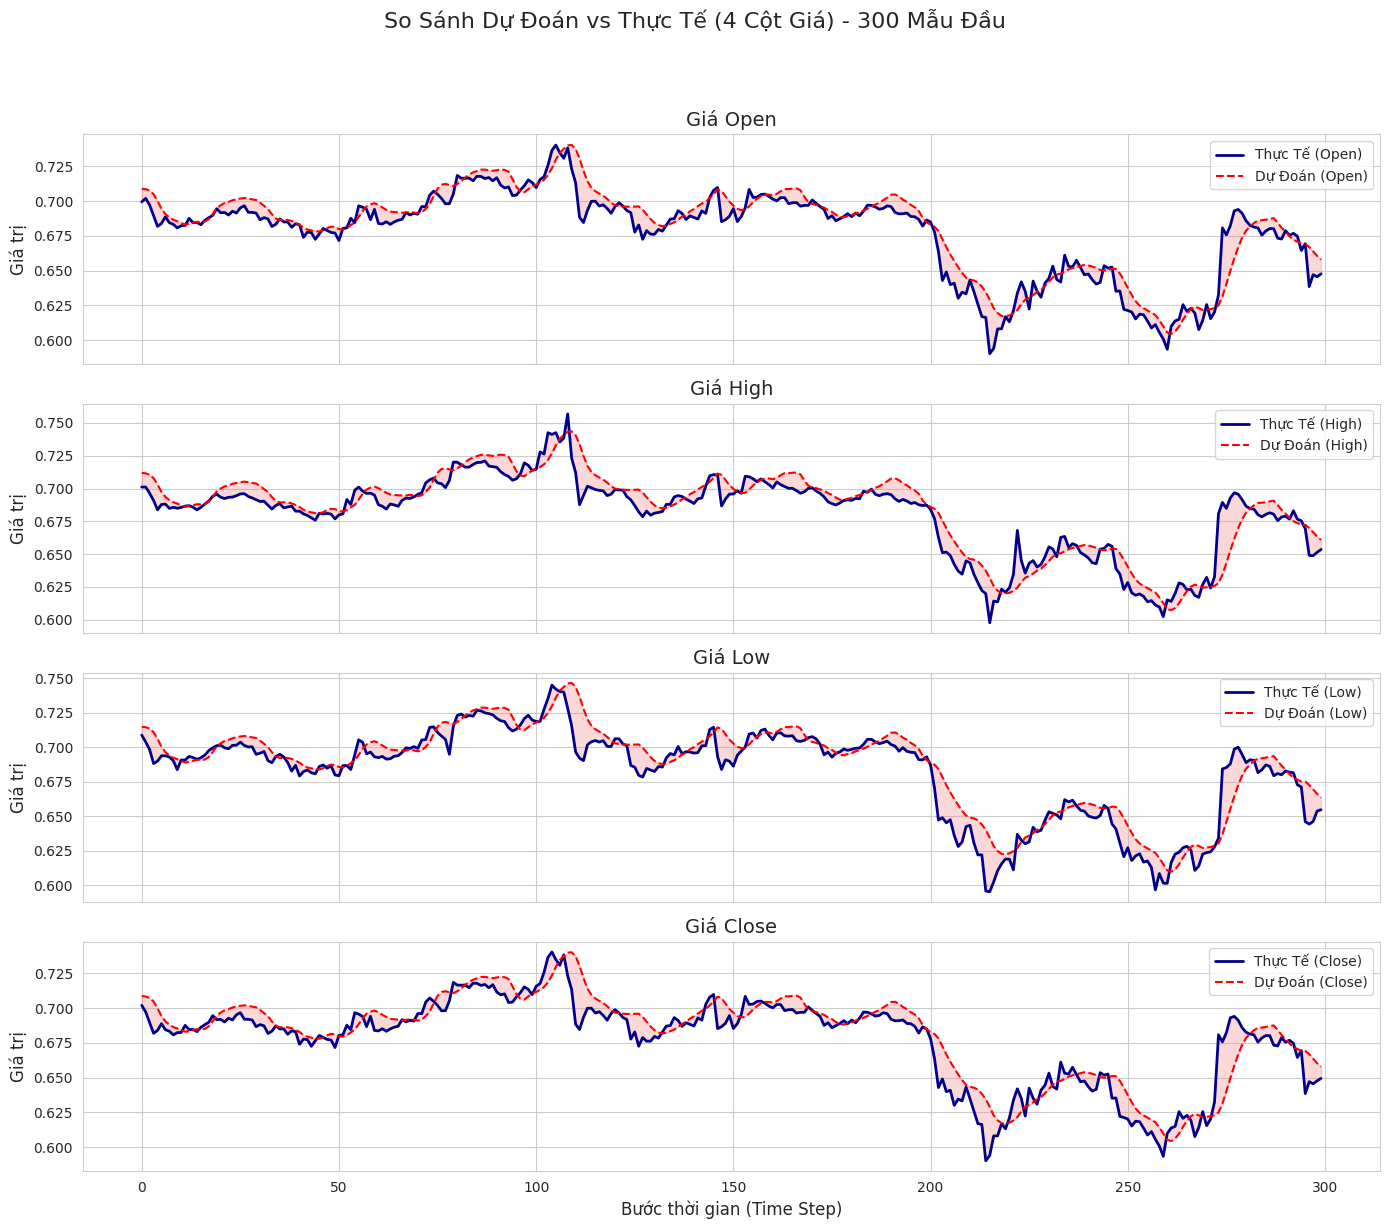

In [ ]:

# 2. Khởi tạo và Huấn luyện mô hình LSTM
lstm_model = LSTM_Model(N_FEATURES,
                        HIDDEN_SIZE,
                        NUM_LAYERS,
                        OUTPUT_SIZE)
final_loss, model_trained, loss_history = train_lstm_model(
    lstm_model, train_loader, valid_loader, "LSTM", MODEL_FOLDER, EPOCHS, LR,
    WEIGHT_DECAY, STEP_SIZE, GAMMA, device, patience=PATIENT)

plot_loss_history(loss_history, title='Lịch sử Loss của Mô hình LSTM')
predict, actual, metrics = predict_and_evaluate(lstm_model, test_loader)
visualize_predictions(predict, actual, num_samples=300)


### LSTM_HYBRID_TRAINING_LOOP

Sử dụng thiết bị: cuda

✅ Dự đoán, thu thập dữ liệu và đánh giá hiệu suất hoàn tất.
Kích thước mảng Dự đoán: (2249, 4)
Kích thước mảng Thực tế: (2249, 4)
--- Chỉ số Hiệu suất ---
MSE: 0.0001
RMSE: 0.0084
MAE: 0.0063
MAPE: 0.7324 %
R2: 0.9951


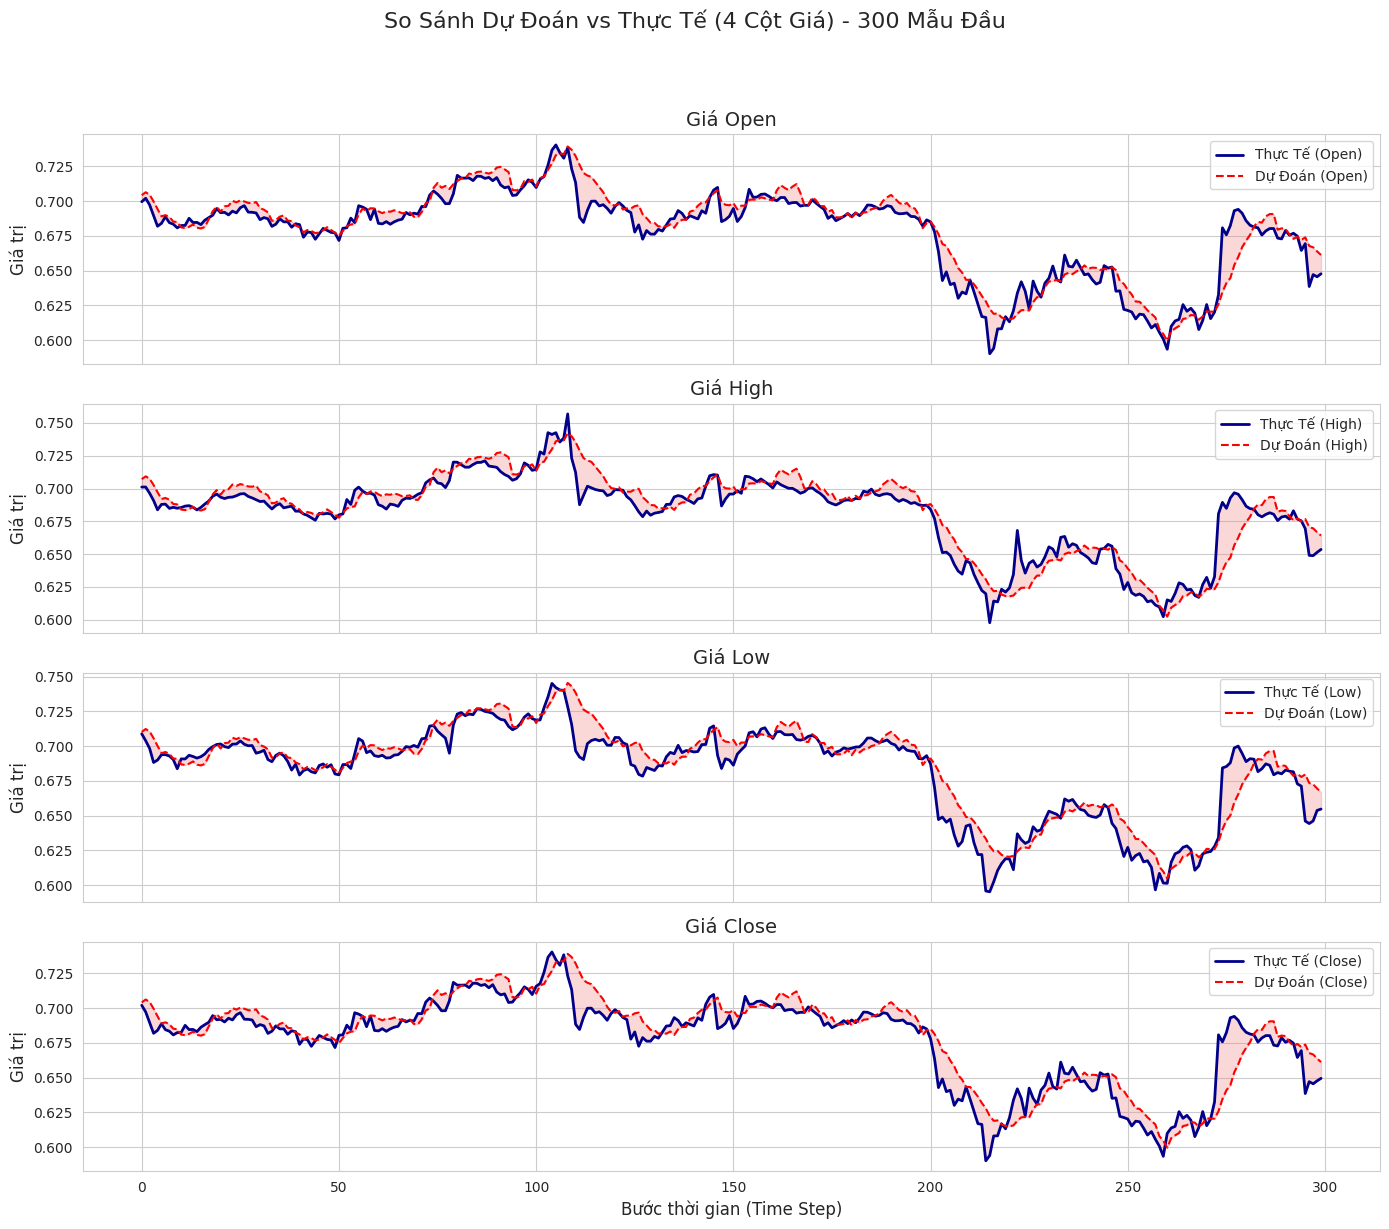

In [ ]:

# lstm_cnn_model = Hybrid_CNN_LSTM(N_FEATURES,
#                         HIDDEN_SIZE,
#                         NUM_LAYERS,
#                         OUTPUT_SIZE,
#                         SEQ_LENGTH)

# # 3. Huan luyen mo hinh LSTM-Hybrid
# final_loss_cnn, model_trained_cnn, loss_history_cnn = train_lstm_model(
#     lstm_cnn_model, train_loader, valid_loader, "LSTM-CNN", MODEL_FOLDER, EPOCHS, LR,
#     WEIGHT_DECAY, STEP_SIZE, GAMMA, device, patience=PATIENT)
# plot_loss_history(loss_history_cnn, title='Lịch sử Loss của Mô hình LSTM-CNN')
predict, actual, metrics = predict_and_evaluate(lstm_cnn_model, test_loader)
visualize_predictions(predict, actual, num_samples=300)

## LSTM_ATTENTION_TRAINING_LOOP

Sử dụng thiết bị: cuda

✅ Dự đoán, thu thập dữ liệu và đánh giá hiệu suất hoàn tất.
Kích thước mảng Dự đoán: (2249, 4)
Kích thước mảng Thực tế: (2249, 4)
--- Chỉ số Hiệu suất ---
MSE: 0.0006
RMSE: 0.0248
MAE: 0.0195
MAPE: 2.1573 %
R2: 0.9579


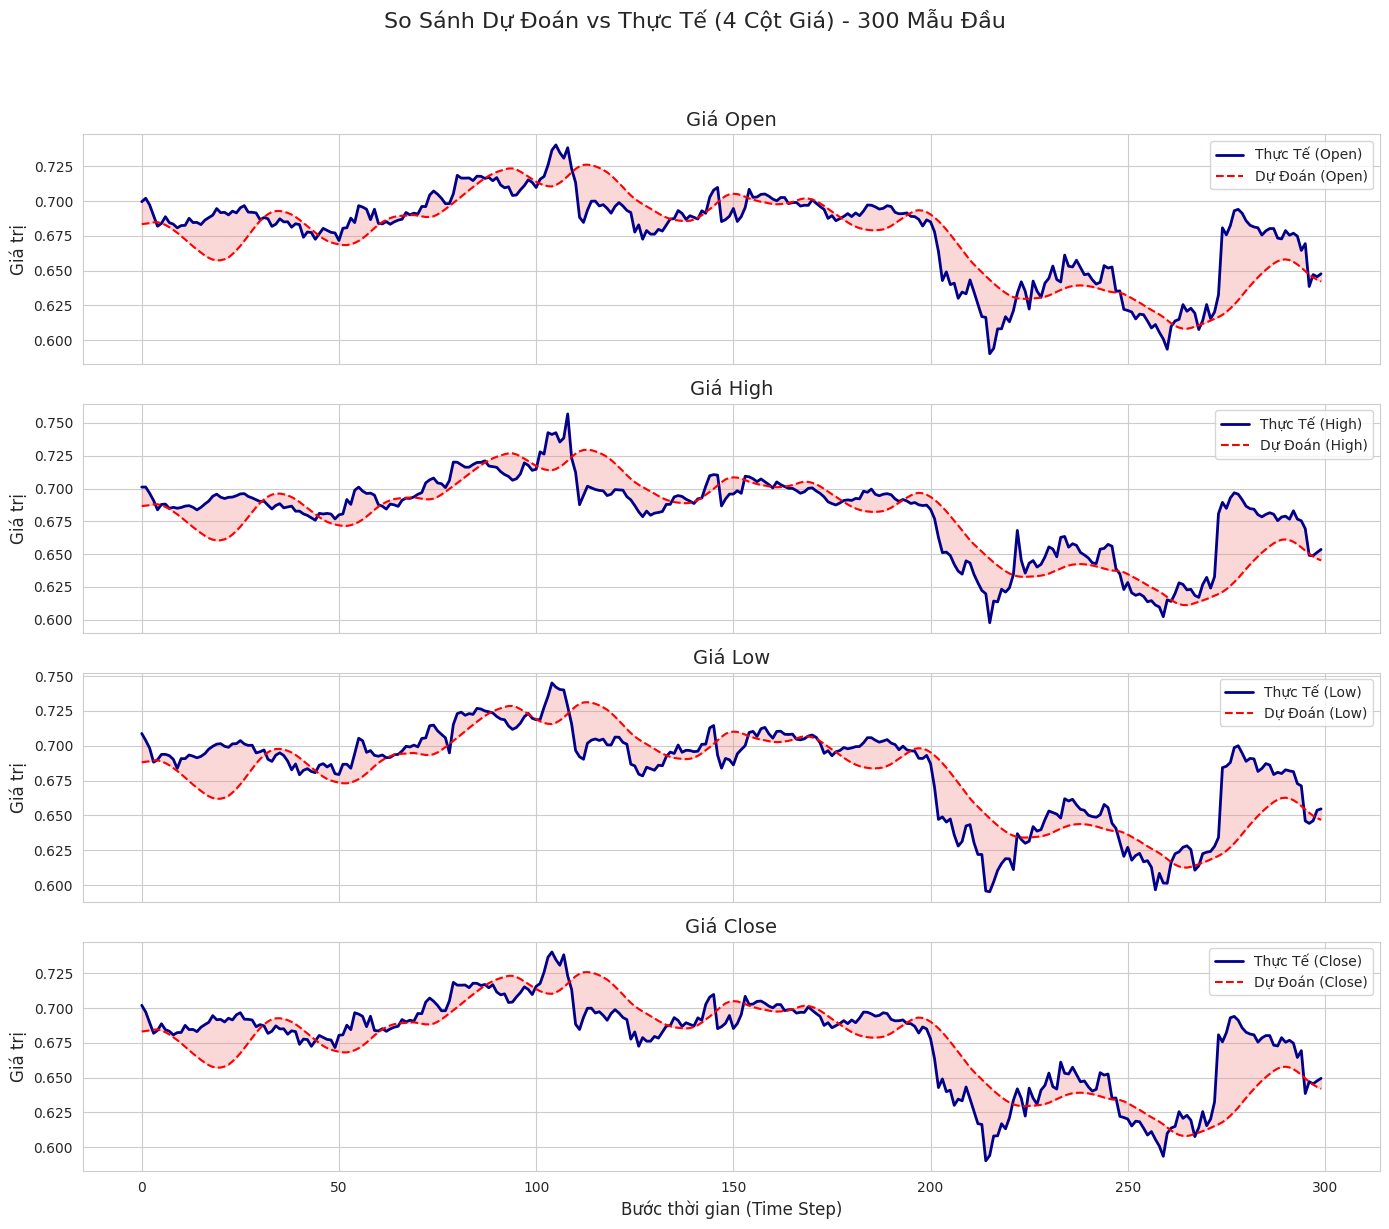

In [ ]:


lstm_atten_model = LSTMAttention(N_FEATURES,
                        HIDDEN_SIZE,
                        OUTPUT_SIZE,
                        NUM_LAYERS)

# 3. Huan luyen mo hinh LSTM-Hybrid
final_loss_atten, model_trained_atten, loss_history_atten = train_lstm_model(
    lstm_atten_model, train_loader, valid_loader, "LSTM-Atten", MODEL_FOLDER, EPOCHS, LR,
    WEIGHT_DECAY, STEP_SIZE, GAMMA, device, patience=PATIENT
)
plot_loss_history(loss_history_atten, title='Lịch sử Loss của Mô hình LSTM-Atten')
predict, actual, metrics = predict_and_evaluate(lstm_atten_model, test_loader)
visualize_predictions(predict, actual, num_samples=300)
#